## Sentiment Analysis | BERT | PyTorch

- [Link](https://www.kaggle.com/code/himanshunayal/sentiment-analysis-bert-hugging-face/notebook)

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
print('Frameworks Imported')

GPU_COUNT = torch.cuda.device_count()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('\nNumber of GPUs Available:', GPU_COUNT, 'is capble to run this model and will utilize', DEVICE, 'as the processor.')

Frameworks Imported

Number of GPUs Available: 1 is capble to run this model and will utilize cuda:0 as the processor.


In [2]:
# Constraints:

IN_DATA = r'E:\inputs'
OUT_DATA = r'E:\outputs'

In [3]:
df = pd.read_csv(r'E:\inputs\reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17082 entries, 0 to 17081
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17082 non-null  object
 1   userName              17082 non-null  object
 2   userImage             17082 non-null  object
 3   content               17082 non-null  object
 4   score                 17082 non-null  int64 
 5   thumbsUpCount         17082 non-null  int64 
 6   reviewCreatedVersion  14297 non-null  object
 7   at                    17082 non-null  object
 8   replyContent          9043 non-null   object
 9   repliedAt             9043 non-null   object
 10  sortOrder             17082 non-null  object
 11  appId                 17082 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.6+ MB


Text(0.5, 0, 'review score')

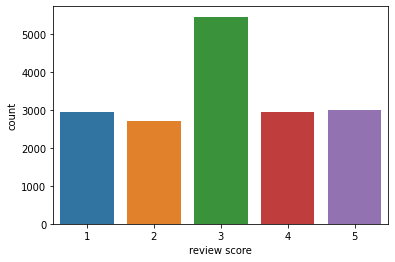

In [4]:
sns.countplot(df.score)
plt.xlabel('review score')

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

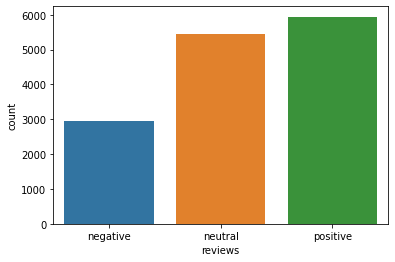

In [5]:
def sentiment(rating):
    if rating < 2:
        return 0
        
    if rating==3:
        return 1
        
    if rating > 3:
        return 2

df['sentiment'] = df.score.apply(sentiment)

ax = sns.countplot(df.sentiment)
plt.xlabel('reviews')
ax.set_xticklabels(['negative', 'neutral', 'positive'])

In [6]:
df = df[df['sentiment'].notna()]

In [7]:
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2179
at                         0
replyContent            7059
repliedAt               7059
sortOrder                  0
appId                      0
sentiment                  0
dtype: int64

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

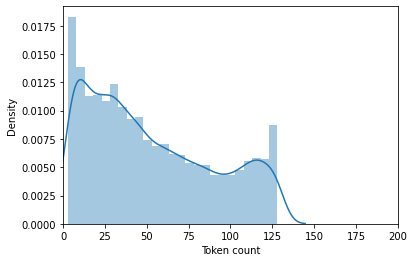

In [9]:
token_lens = []

for text in df.content:
    tokens = tokenizer.encode(text,max_length=128)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count')

In [10]:
class CustomDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        super().__init__()
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self,item):
        review = self.reviews[item]
        target = self.targets[item]
        
        encoding = tokenizer.encode_plus(
            review,
            max_length = self.max_len,
            add_special_tokens = True, 
            pad_to_max_length = True,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors = 'pt' 
        )
        
        return {
            'review': review,
            'target': torch.tensor(target,dtype=torch.long),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [ ]:
MAX_LEN = 160
BATCH_SIZE = 16
RANDOM_SEED = 2002
EPOCHS = 10

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

In [ ]:
ds = CustomDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
    )

In [ ]:
def Data_Loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
                ds,
                batch_size=batch_size,
                num_workers=4
             )

In [ ]:
train_data_loader = Data_Loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = Data_Loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = Data_Loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [44]:
data = next(iter(train_data_loader))
print(data.keys())

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target'].shape)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
                                        input_ids = encoding['input_ids'],
                                        attention_mask = encoding['attention_mask'],
                                        return_dict=False
                                    )